In [1]:
  # <reference>

# main
# https://github.com/wusaifei/HWCC_image_classification/blob/master/src/train.py

# data_transforms2
# https://github.com/Anjum48/rsna-ich

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install efficientnet_pytorch
!pip install pydicom

# -*- coding: utf-8 -*-
from torchvision import datasets, transforms, models
import torch
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data.dataloader import default_collate
from efficientnet_pytorch import EfficientNet
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import glob
import os
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from PIL import Image

In [4]:
data_dir = "/content/drive/Shared drives/數位醫學/Case Presentation 2"

# hyper parameters
num_classes = 6
batch_size = 16
#EPOCH = 150
EPOCH = 50
input_size = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# windowing
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
      correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    #soft_img = window_image(dcm, 40, 380)
    bone_img = window_image(dcm , 600 , 2800)

    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    #soft_img = (soft_img - (-150)) / 380
    bone_img = (bone_img - (-800)) / 2800

    #bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    bsb_img = np.array([brain_img, subdural_img, bone_img]).transpose(1,2,0)

    return bsb_img

In [6]:
class myDataset(Dataset):
  def __init__(self, folder, classes, transform=None):

    self.dictonary = {'epidural':0, 'healthy':1, 'intraparenchymal':2, 'intraventricular':3, 'subarachnoid':4, 'subdural':5}
    self.path = []
    self.label = []
    self.transform = transform

    # train data
    # self.path存dcm的path
    # self.label存dcm的label
    if len(classes) > 0:
      for i in classes:
        for j in glob.glob(folder + '/' + i + '/*'):
          self.path.append(j)
          self.label.append(self.dictonary[i])
    # test data的部分之後寫
    # 可能再寫一個test data的myDataset
    #else:
      #pass

  def __len__(self):
    return len(self.path)
 
  def __getitem__(self, idx):
    #img = torch.from_numpy(bsb_window(pydicom.dcmread(self.path[idx])).transpose(2, 0, 1)).type(torch.FloatTensor)

    img = bsb_window(pydicom.dcmread(self.path[idx])) # C*H*W => H*W*C
    # 以下動作使得圖片得以轉為PIL，才能使用部分的transform
    img *= 255 # [0., 1.] => [0., 255.]
    img = img.astype(np.uint8) # [0., 255.] => [0, 255]
    img = Image.fromarray(img) # numpy => PIL

    #print(np.max(np.array(img)), np.min(np.array(img)), np.mean(np.array(img)), np.median(np.array(img)))
    if self.transform:
      img = self.transform(img)
    #print(torch.max(img), torch.min(img), torch.mean(img), torch.median(img))
    return img, self.label[idx]

classes = ['epidural', 'healthy', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

# data augmentation
data_transforms2 = transforms.Compose([
  #transforms.ToPILImage(),                                       
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(degrees=15),
  transforms.RandomResizedCrop(input_size, scale=(0.85, 1.0), ratio=(0.8, 1.2)),
  transforms.ToTensor(), # PIL => FloatTensor，[0, 255] => [0., 1.]
])

TrainDataset = myDataset(folder='/content/drive/Shared drives/數位醫學/Case Presentation 2/TrainingData_tmp', classes=classes, transform=data_transforms2)


validation_split = .1
shuffle_dataset = True
random_seed = 2020

dataset_size = len(TrainDataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(TrainDataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(TrainDataset, batch_size=batch_size, sampler=valid_sampler, num_workers=4)

In [7]:
# load pretrained weight(trained from ImageNet)
net = models.inception_v3(pretrained=True)
#set_parameter_requires_grad(net, feature_extract)
# Handle the auxilary net
num_ftrs = net.AuxLogits.fc.in_features
net.AuxLogits.fc = nn.Linear(num_ftrs, 6)
# Handle the primary net
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs,6)
#net.dropout = nn.Dropout(0.95)
net = net.to(device)
input_size = 512

In [8]:
ii = 0
LR = 0.0005  # learning rate
best_acc = 0  # initialize best test accuracy

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
#optimizer = optim.Adam(net.parameters(), lr=LR)
#optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-9)
optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-9, weight_decay=1e-5)
#optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)

In [9]:

import datetime
## modified region ## 
iter_train = []
loss_train = []
loss_val = []
acc_train = []
valid_acc_train = [] 
epoch_train = []
## modified region ## 
##-------AUC-------##
y_label=[] 
y_score=[]
##-------AUC-------##
best_val_acc = 0.0
## modfied region (11/13 09:41) ##
BEST_LOSS_VAL = 10.0
## modfied region (11/13 09:41) ##
for epoch in range(EPOCH):
  net.train()
  sum_loss = 0.0
  correct = 0.0
  total = 0.0
  ## modified region ## 
  LOSS_TRAIN = 0.0
  starttime = datetime.datetime.now()
  # training
  for i, data in enumerate(train_loader, 0):
    length = len(train_loader)
    input, target = data
    #print(target, type(target))
    input, target = input.to(device), target.to(device)
    
    optimizer.zero_grad()

    #output = net(input)
    output, aux_outputs = net(input)
    #loss = criterion(output, target)
    loss1 = criterion(output, target)
    loss2 = criterion(aux_outputs, target)
    loss = loss1 + 0.4*loss2
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    correct += predicted.eq(target.data).cpu().sum()
    if i % 80 == 0:
      print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% ' 
        % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1),
        100. * float(correct) / float(total)))
    LOSS_TRAIN = sum_loss / (i + 1)

  ## modified region ##    
  epoch_train.append(epoch)
  loss_train.append(LOSS_TRAIN)
  acc_train.append(100. * float(correct) / float(total))   
  ## modified region ## 

   
  # validation
  with torch.no_grad():
    correct = 0
    total = 0
    val_sum_loss = 0
    LOSS_VAL = 0
    for i, data in enumerate(validation_loader, 0):
      net.eval()
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      ## modfied region (11/13 09:41) ##
      optimizer.zero_grad()
      ## modfied region (11/13 09:41) ##

      #outputs = net(images)
      output = net(images)
      loss = criterion(output, labels)
      val_sum_loss += loss.item()
      # 取得分最高的那個類 (outputs.data的索引號)
      _, predicted = torch.max(output.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).cpu().sum()
      LOSS_VAL = val_sum_loss / (i + 1)
      #------------FOR AUC----------------
      for j in output:
        j.cpu().numpy()
        y_score.append(j)
      for p,l in zip(predicted, labels):
        y_label.append(l.cpu().numpy())
      #------------FOR AUC----------------
    print('validation loss:', LOSS_VAL)
    loss_val.append(LOSS_VAL)
    print('validation accuracy：%.3f%%' % (100. * float(correct) / float(total)))
    ## modified region ## 
    valid_acc_train.append(100. * float(correct) / float(total))
    ## modified region ## 
    acc = 100. * float(correct) / float(total)
    if acc > best_val_acc:
      print("save weight!! (acc)")
      torch.save(net, '/content/drive/Shared drives/數位醫學/Case Presentation 2/Implementation/weights/model=inceptionv3_acc.pkl')
      best_val_acc = acc
    ## modfied region (11/13 09:41) ##
    if LOSS_VAL < BEST_LOSS_VAL:
      print("save weight!! (loss)")
      torch.save(net, '/content/drive/Shared drives/數位醫學/Case Presentation 2/Implementation/weights/model=inceptionv3_loss.pkl')
      BEST_LOSS_VAL = LOSS_VAL
    ## modfied region (11/13 09:41) ##
    scheduler.step(acc)
  endtime = datetime.datetime.now()
  print((endtime - starttime).seconds," seconds")
    


print("Training Finished, Total EPOCH=%d" % EPOCH)

[epoch:1, iter:1] Loss: 2.799 | Acc: 0.000% 
[epoch:1, iter:81] Loss: 2.352 | Acc: 29.090% 
[epoch:1, iter:161] Loss: 2.255 | Acc: 33.540% 
[epoch:1, iter:241] Loss: 2.190 | Acc: 36.177% 
[epoch:1, iter:321] Loss: 2.122 | Acc: 38.882% 
validation loss: 1.4547796421929409
validation accuracy：45.333%
save weight!! (acc)
save weight!! (loss)
157  seconds
[epoch:2, iter:339] Loss: 1.845 | Acc: 37.500% 
[epoch:2, iter:419] Loss: 1.869 | Acc: 50.000% 
[epoch:2, iter:499] Loss: 1.839 | Acc: 49.884% 
[epoch:2, iter:579] Loss: 1.825 | Acc: 49.689% 
[epoch:2, iter:659] Loss: 1.809 | Acc: 50.175% 
validation loss: 1.2270921766757965
validation accuracy：54.333%
save weight!! (acc)
save weight!! (loss)
158  seconds
[epoch:3, iter:677] Loss: 1.980 | Acc: 31.250% 
[epoch:3, iter:757] Loss: 1.643 | Acc: 57.176% 
[epoch:3, iter:837] Loss: 1.635 | Acc: 56.638% 
[epoch:3, iter:917] Loss: 1.617 | Acc: 57.287% 
[epoch:3, iter:997] Loss: 1.602 | Acc: 57.360% 
validation loss: 1.162624589706722
validation ac

KeyboardInterrupt: ignored

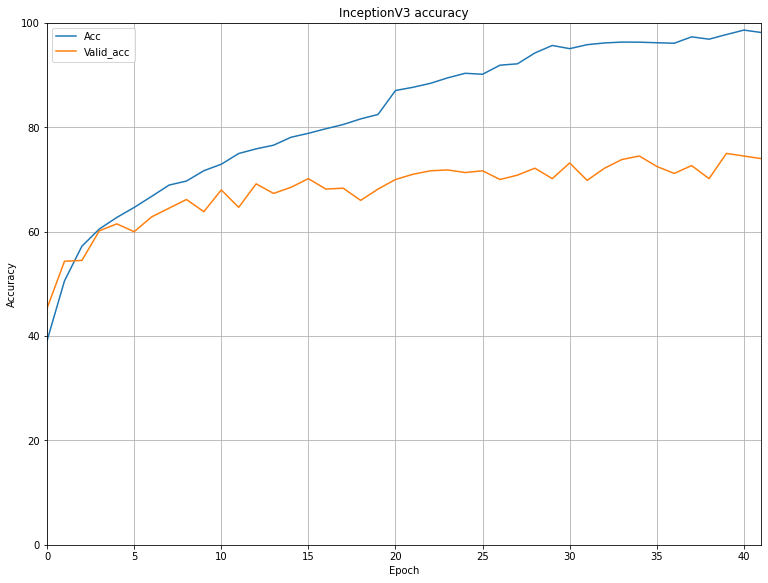

<Figure size 432x288 with 0 Axes>

In [16]:


plt.figure(figsize=(12.8, 9.6)) 
plt.xlabel("Epoch")
plt.xlim(0 , len(epoch_train)-1)
plt.ylim(0 , 100)
plt.ylabel("Accuracy") 
plt.title("InceptionV3 accuracy")
plt.plot(epoch_train , acc_train , label = "Acc")
#plt.plot(epoch_train , loss_train , label = "Loss")
plt.plot(epoch_train , valid_acc_train , label = "Valid_acc")
plt.legend(loc="upper left")
plt.grid()
plt.show()  
plt.savefig("InceptionV3.jpg")



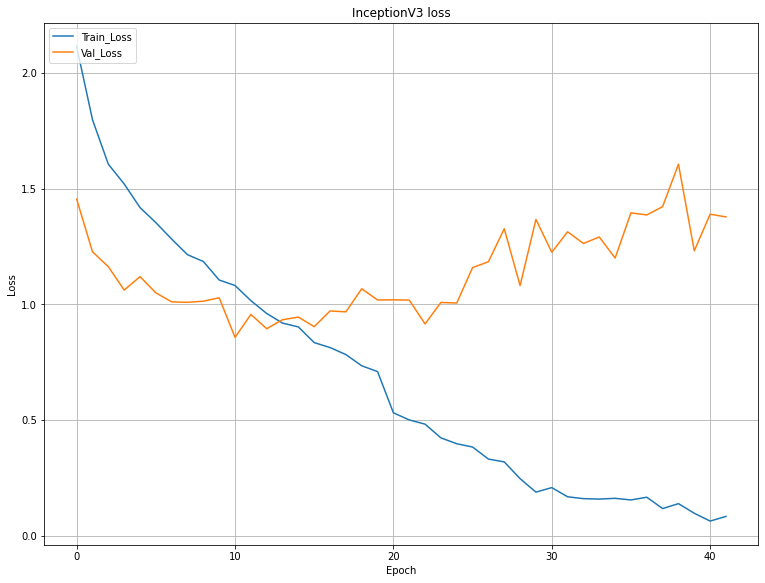

In [19]:
plt.figure(figsize=(12.8, 9.6)) 
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("InceptionV3 loss")
#plt.ylim(0 , 4)
plt.grid()
plt.plot(epoch_train , loss_train , label = "Train_Loss")
plt.plot(epoch_train , loss_val, label='Val_Loss')
plt.legend(loc="upper left")

In [ ]:
## modfied region (11/13 09:41) ##
y_score_tmp = y_score
y_label_tmp = y_label
## modfied region (11/13 09:41) ##
len(y_label)

In [ ]:
a = []
for i in range(len(y_score)):
  a.append((y_score[i][y_label[i+42000]]))
plt.hist(np.array(a), bins=20)

In [ ]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp


y_score = np.array([F.softmax(x.to("cpu"),dim=0).numpy().tolist() for x in y_score])
y_label = [x.item() for x in y_label]
one_hot_label = []

for i in range(len(y_label)):
  six_zero = [0, 0, 0, 0, 0, 0]
  six_zero[y_label[i]] = 1
  one_hot_label.append(six_zero)
one_hot_label = np.array(one_hot_label)


n_classes = 6
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(one_hot_label[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# macro（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
 
# Plot all ROC curves
lw=2
plt.figure()
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lime', 'violet', 'hotpink'])

classes_name = ['epidural', 'healthy', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(classes_name[i], roc_auc[i]))

plt.rcParams["figure.figsize"] = (50,50)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-calss ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()